In [19]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
import cv2  # 用於 Laplacian 銳利度測量

## 讀取csv檔 分成 1. 預測錯誤   2. 預測正確但信心不高

In [15]:
import pandas as pd

# 讀取結果 CSV
df = pd.read_csv(r"C:\Users\Vivo\2025_medicalimage_and_AI\test_result\ResNet34\mdResNet34_test_result.csv")

df["body_part"] = df["study_folder"].apply(lambda x: x.split("\\")[0])

# 1. 找出錯誤預測
incorrect_preds = df[df["predicted_label"] != df["ground_truth_label"]]

# 2. 找出正確但信心機率低預測（例如低於 0.6）
threshold = 0.6
correct_low_conf = df[
    (df["predicted_label"] == df["ground_truth_label"]) & (
        ((df["ground_truth_label"] == 1) & (df["predicted_prob"] < threshold)) |
        ((df["ground_truth_label"] == 0) & (df["predicted_prob"] > 1 - threshold))
    )
]

# 3. 找出正確且信心機率高的預測（例如高於 0.9）
threshold_high = 0.9
correct_high_conf = df[
    (df["predicted_label"] == df["ground_truth_label"]) & (
        ((df["ground_truth_label"] == 1) & (df["predicted_prob"] > threshold_high)) |
        ((df["ground_truth_label"] == 0) & (df["predicted_prob"] < 1 - threshold_high))
    )
]



print("錯誤預測的詳細資料:")
print("錯誤預測的數量:", len(incorrect_preds))
print(incorrect_preds[["predicted_label", "ground_truth_label", "predicted_prob", "body_part"]].head(3))
print("----------------------------------------")
print("正確但信心機率低的預測的詳細資料:")
print("正確但信心機率低的預測數量:", len(correct_low_conf))
print(correct_low_conf[["predicted_label", "ground_truth_label", "predicted_prob", "body_part"]].head(3))
print("----------------------------------------")
print("正確且信心機率高的預測的詳細資料:")  
print("正確且信心機率高的預測數量:", len(correct_high_conf))
print(correct_high_conf[["predicted_label", "ground_truth_label", "predicted_prob", "body_part"]].head(3))


錯誤預測的詳細資料:
錯誤預測的數量: 261
    predicted_label  ground_truth_label  predicted_prob body_part
4                 0                   1        0.213924  XR_WRIST
10                0                   1        0.132066  XR_WRIST
18                0                   1        0.453022  XR_WRIST
----------------------------------------
正確但信心機率低的預測的詳細資料:
正確但信心機率低的預測數量: 69
    predicted_label  ground_truth_label  predicted_prob body_part
14                1                   1        0.507317  XR_WRIST
23                1                   1        0.579331  XR_WRIST
26                1                   1        0.577813  XR_WRIST
----------------------------------------
正確且信心機率高的預測的詳細資料:
正確且信心機率高的預測數量: 365
   predicted_label  ground_truth_label  predicted_prob body_part
1                1                   1        0.929898  XR_WRIST
2                1                   1        0.994040  XR_WRIST
3                1                   1        0.965011  XR_WRIST


## 找出這兩類中， 部位占比多少?

In [16]:

# 3. 統計各部位出現次數
incorrect_stats = incorrect_preds["body_part"].value_counts()
correct_low_stats = correct_low_conf["body_part"].value_counts()
correct_high_stats = correct_high_conf["body_part"].value_counts()

# 4. 顯示統計結果
print("錯誤預測數量（每個部位）:")
print(incorrect_stats)

print("\n正確但低信心預測數量（每個部位）:")
print(correct_low_stats)

print("\n正確且高信心預測數量（每個部位）:")
print(correct_high_stats)

錯誤預測數量（每個部位）:
body_part
XR_SHOULDER    66
XR_FINGER      41
XR_WRIST       40
XR_HAND        36
XR_ELBOW       29
XR_HUMERUS     27
XR_FOREARM     22
Name: count, dtype: int64

正確但低信心預測數量（每個部位）:
body_part
XR_WRIST       18
XR_SHOULDER    16
XR_FINGER      13
XR_HAND         7
XR_FOREARM      6
XR_HUMERUS      5
XR_ELBOW        4
Name: count, dtype: int64

正確且高信心預測數量（每個部位）:
body_part
XR_WRIST       92
XR_FINGER      55
XR_ELBOW       49
XR_SHOULDER    48
XR_FOREARM     45
XR_HUMERUS     44
XR_HAND        32
Name: count, dtype: int64


## 找出這些圖片的資訊 (灰度分布、對比度、銳利度)

### 1. 讀取這些圖片

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
from tqdm import tqdm  
from glob import glob

# 基本設定
base_path = r"C:\Users\Vivo\2025_medicalimage_and_AI\MURA-v1.1\valid"
to_tensor = transforms.ToTensor()

# 定義影像處理的轉換
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 調整尺寸
    transforms.Grayscale(num_output_channels=1),  # 轉為三通道灰階影像
    transforms.ToTensor(),  # 轉換為 Tensor
])

# 初始化影像暫存列表
incorrect_images = []
low_conf_images = []
high_con_images = []

def process_study(study_relative_path):
    full_path = os.path.join(base_path, study_relative_path)
    
    # 使用 glob 來取得所有符合條件的影像文件
    image_paths = glob(os.path.join(full_path, '*.png'))
    image_tensors = []

    for img_path in image_paths:
        img = Image.open(img_path).convert('L')  # 灰階
        img = transform(img)  # 應用轉換
        image_tensors.append(img)
    
    if len(image_tensors) == 0:
        return None  # 沒圖片就跳過

    # 疊加平均：[N, H, W] -> mean: [H, W]
    stacked = torch.stack(image_tensors, dim=0)
    mean_img = stacked.mean(dim=0)  # [3, H, W]
    return mean_img

# 對錯誤預測處理
print("處理錯誤預測影像...")
for path in tqdm(incorrect_preds["study_folder"]):
    img = process_study(path)
    if img is not None:
        incorrect_images.append(img)

# 對低信心正確預測處理
print("處理低信心預測影像...")
for path in tqdm(correct_low_conf["study_folder"]):
    img = process_study(path)
    if img is not None:
        low_conf_images.append(img)

# 對高信心正確預測處理
print("處理高信心預測影像...")
for path in tqdm(correct_high_conf["study_folder"]):
    img = process_study(path)
    if img is not None:
        high_con_images.append(img)
        



處理錯誤預測影像...


100%|██████████| 261/261 [00:02<00:00, 104.31it/s]


處理低信心預測影像...


100%|██████████| 69/69 [00:00<00:00, 95.88it/s] 


處理高信心預測影像...


100%|██████████| 365/365 [00:03<00:00, 115.56it/s]


✅ 所有平均影像已儲存完成，位於： C:\Users\Vivo\2025_medicalimage_and_AI\automl


In [67]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_histogram(tensor_image):
    # 轉為 numpy，還原為 uint8 灰度（0~255）
    image = (tensor_image[0].numpy() * 255).astype(np.uint8)
    hist = np.bincount(image.flatten(), minlength=256)
    return hist

# 計算亮度（灰度的均值）
def calculate_brightness(tensor_image):
    image = tensor_image[0].numpy()  # 轉為灰階
    return np.mean(image)

# 計算銳利度（使用拉普拉斯算子）
def calculate_sharpness(tensor_image):
    image = tensor_image[0].numpy()  # 轉為灰階
    if len(image.shape) > 2:  # 如果是彩色圖像
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 轉為灰度圖像
    image = image.astype(np.float32)  # 確保是 float32
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)  # 正規化範圍到 0-255
    image = image.astype(np.uint8)  # 將數據轉換為 uint8 類型
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    return np.var(laplacian)

# 計算對比度（最大值 - 最小值）
def calculate_contrast(tensor_image):
    image = tensor_image[0].numpy()  # 轉為灰階
    return image.max() - image.min()

# 計算標準差
def calculate_std(tensor_image):
    image = tensor_image[0].numpy()  # 轉為灰階
    return np.std(image)

# 用來處理每組影像資料
def process_images(image_tensors):
    histograms = []
    brightness = []
    sharpness = []
    contrast = []
    std_devs = []
    
    for tensor_img in tqdm(image_tensors):
        # 計算各種特徵
        histograms.append(calculate_histogram(tensor_img))
        brightness.append(calculate_brightness(tensor_img))
        sharpness.append(calculate_sharpness(tensor_img))
        contrast.append(calculate_contrast(tensor_img))
        std_devs.append(calculate_std(tensor_img))
    
    return histograms, brightness, sharpness, contrast, std_devs

# 分別處理每組影像資料
incorrect_histograms, incorrect_brightness, incorrect_sharpness, incorrect_contrast, incorrect_std = process_images(incorrect_images)
low_conf_histograms, low_conf_brightness, low_conf_sharpness, low_conf_contrast, low_conf_std = process_images(low_conf_images)
high_conf_histograms, high_conf_brightness, high_conf_sharpness, high_conf_contrast, high_conf_std = process_images(high_con_images)


100%|██████████| 365/365 [00:00<00:00, 1361.62it/s]


### 平均灰度分布

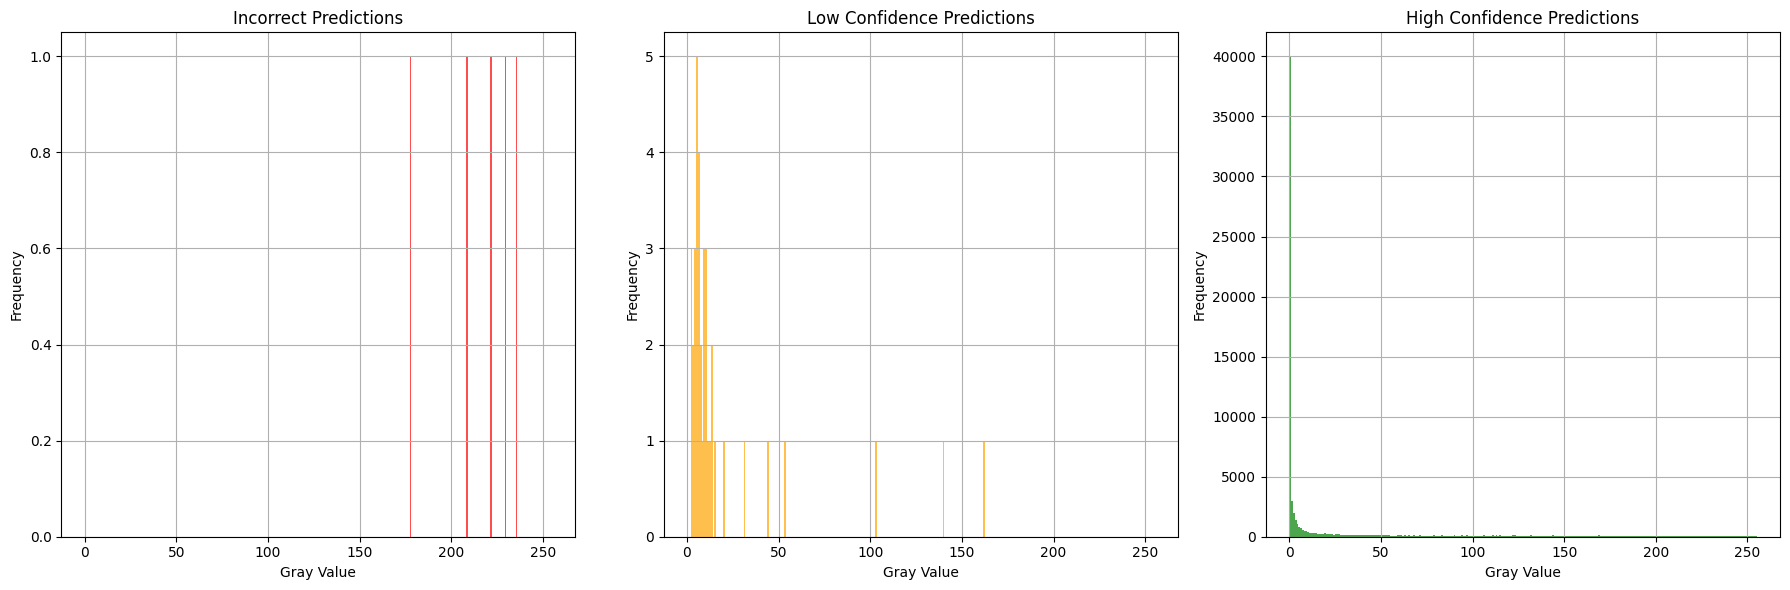

In [68]:
import matplotlib.pyplot as plt

# 繪製單獨的灰度分布圖
def plot_histograms_separate(incorrect_hist_sum, low_conf_hist_sum, high_conf_hist_sum):
    # 創建子圖（每個預測類型一個圖）
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 繪製錯誤預測的灰度分佈
    axes[0].hist(incorrect_hist_sum, bins=256, alpha=0.7, label="Incorrect Predictions", color="red", range=(0, 255))
    axes[0].set_title("Incorrect Predictions")
    axes[0].set_xlabel("Gray Value")
    axes[0].set_ylabel("Frequency")
    axes[0].grid(True)

    # 繪製低信心預測的灰度分佈
    axes[1].hist(low_conf_hist_sum, bins=256, alpha=0.7, label="Low Confidence Predictions", color="orange", range=(0, 255))
    axes[1].set_title("Low Confidence Predictions")
    axes[1].set_xlabel("Gray Value")
    axes[1].set_ylabel("Frequency")
    axes[1].grid(True)
    
    # 合并所有高信心预测的灰度分布数据
    high_conf_hist_combined = np.concatenate(high_conf_histograms)

    # 绘制高信心预测的灰度分布
    axes[2].hist(high_conf_hist_combined, bins=256, alpha=0.7, label="High Confidence Predictions", color="green", range=(0, 255))
    axes[2].set_title("High Confidence Predictions")
    axes[2].set_xlabel("Gray Value")
    axes[2].set_ylabel("Frequency")
    axes[2].grid(True)

    # 显示图形
    plt.tight_layout()
    plt.show()

# 呼叫繪圖函數
incorrect_hist_sum = np.sum(incorrect_histograms, axis=0)
low_conf_hist_sum = np.sum(low_conf_histograms, axis=0)
high_conf_hist_sum = np.sum(high_conf_histograms, axis=0)
plot_histograms_separate(incorrect_hist_sum, low_conf_hist_sum, high_conf_hist_sum)




### 亮度

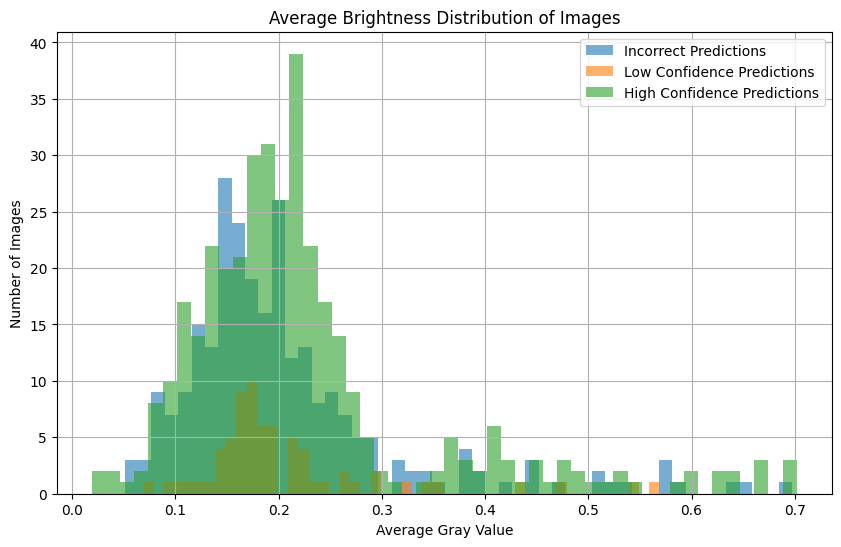

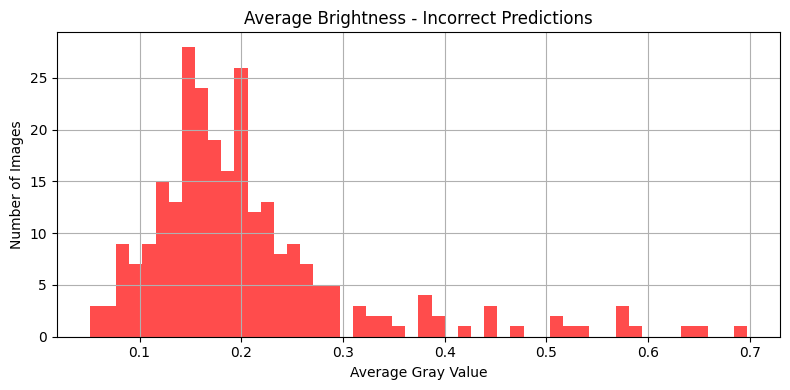

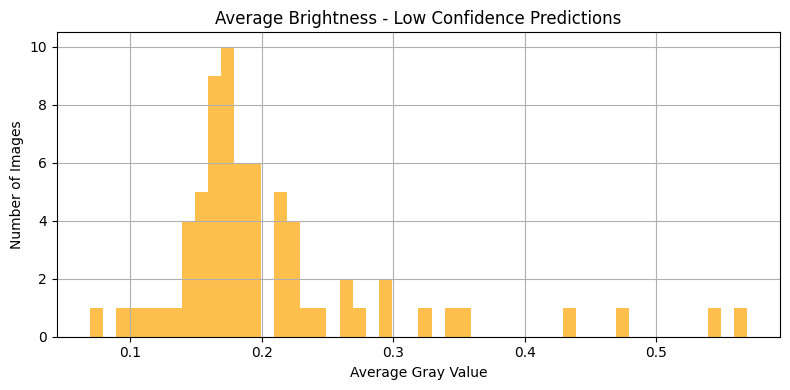

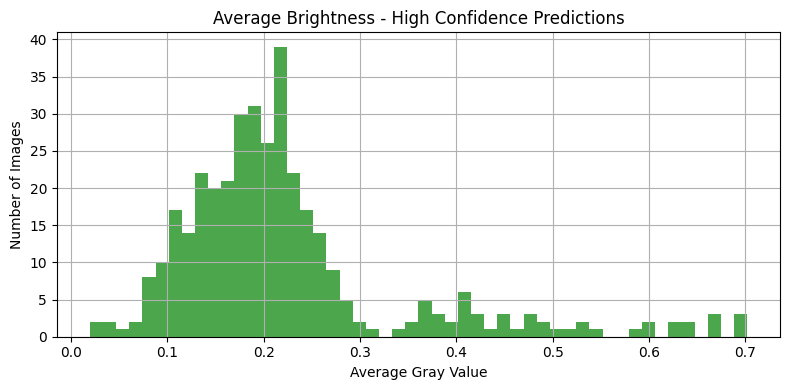

In [69]:
plt.figure(figsize=(10, 6))
plt.hist(incorrect_brightness, bins=50, alpha=0.6, label="Incorrect Predictions")
plt.hist(low_conf_brightness, bins=50, alpha=0.6, label="Low Confidence Predictions")
plt.hist(high_conf_brightness, bins=50, alpha=0.6, label="High Confidence Predictions")
plt.title("Average Brightness Distribution of Images")
plt.xlabel("Average Gray Value")
plt.ylabel("Number of Images")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Incorrect Predictions
plt.figure(figsize=(8, 4))
plt.hist(incorrect_brightness, bins=50, color='red', alpha=0.7)
plt.title("Average Brightness - Incorrect Predictions")
plt.xlabel("Average Gray Value")
plt.ylabel("Number of Images")
plt.grid(True)
plt.tight_layout()
plt.show()

# Low Confidence Predictions
plt.figure(figsize=(8, 4))
plt.hist(low_conf_brightness, bins=50, color='orange', alpha=0.7)
plt.title("Average Brightness - Low Confidence Predictions")
plt.xlabel("Average Gray Value")
plt.ylabel("Number of Images")
plt.grid(True)
plt.tight_layout()
plt.show()

# High Confidence Predictions
plt.figure(figsize=(8, 4))
plt.hist(high_conf_brightness, bins=50, color='green', alpha=0.7)
plt.title("Average Brightness - High Confidence Predictions")
plt.xlabel("Average Gray Value")
plt.ylabel("Number of Images")
plt.grid(True)
plt.tight_layout()
plt.show()


### 銳利度

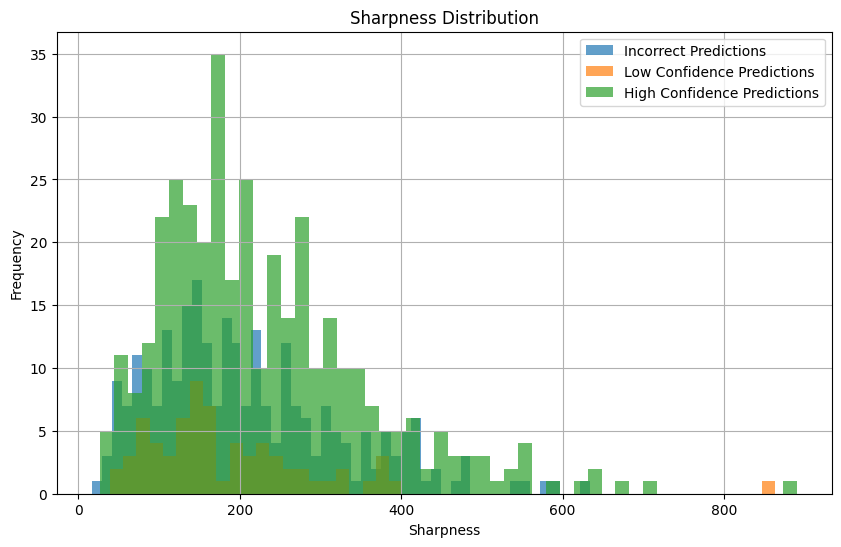

In [70]:
plt.figure(figsize=(10, 6))
plt.hist(incorrect_sharpness, bins=50, alpha=0.7, label="Incorrect Predictions")
plt.hist(low_conf_sharpness, bins=50, alpha=0.7, label="Low Confidence Predictions")
plt.hist(high_conf_sharpness, bins=50, alpha=0.7, label="High Confidence Predictions")
plt.title("Sharpness Distribution")
plt.xlabel("Sharpness")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

### 對比度

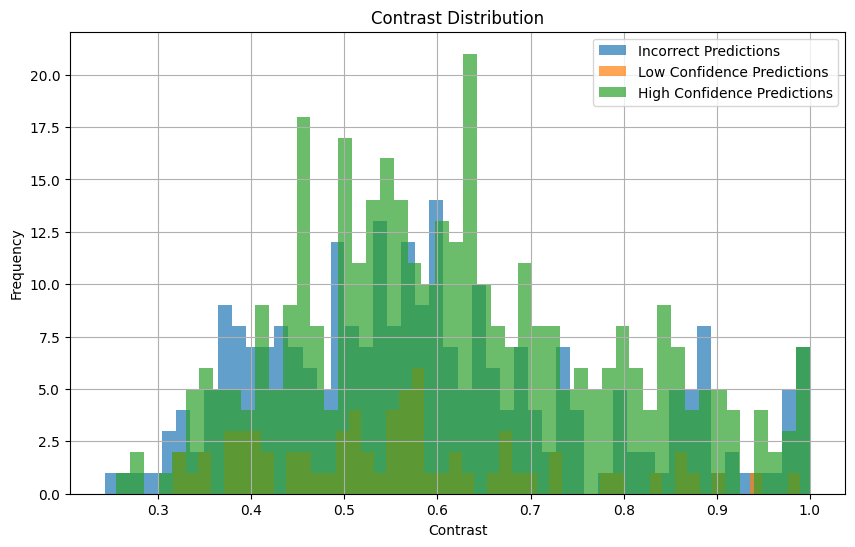

In [71]:
# 4. 對比度分佈
plt.figure(figsize=(10, 6))
plt.hist(incorrect_contrast, bins=50, alpha=0.7, label="Incorrect Predictions")
plt.hist(low_conf_contrast, bins=50, alpha=0.7, label="Low Confidence Predictions")
plt.hist(high_conf_contrast, bins=50, alpha=0.7, label="High Confidence Predictions")
plt.title("Contrast Distribution")
plt.xlabel("Contrast")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

### 標準差

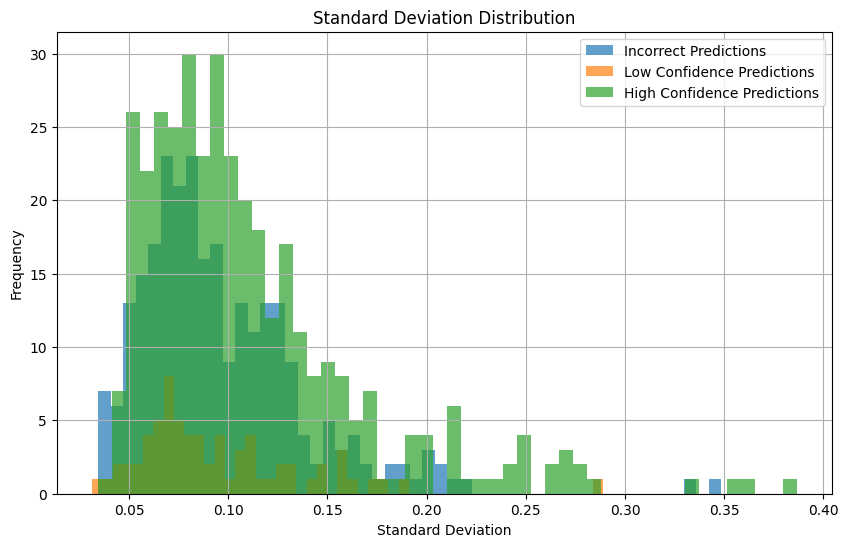

In [72]:
# 5. 標準差分佈
plt.figure(figsize=(10, 6))
plt.hist(incorrect_std, bins=50, alpha=0.7, label="Incorrect Predictions")
plt.hist(low_conf_std, bins=50, alpha=0.7, label="Low Confidence Predictions")
plt.hist(high_conf_std, bins=50, alpha=0.7, label="High Confidence Predictions")
plt.title("Standard Deviation Distribution")
plt.xlabel("Standard Deviation")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

### 相似度比較

In [80]:
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim

def calculate_similarity_and_mae(image_list_1, image_list_2, label_1, label_2):
    ssim_results = []
    mae_results = []

    for img1 in tqdm(image_list_1, desc=f'Processing {label_1} vs {label_2}'):
        for img2 in image_list_2:
            # 计算 SSIM (首先将 Tensor 转换为 NumPy 数组)
            img1_np = img1.squeeze().numpy()  # [1, H, W] -> [H, W]
            img2_np = img2.squeeze().numpy()  # [1, H, W] -> [H, W]
            
            # 确保 data_range 的值为 1（假设图像像素范围是 0-1）
            ssim_index, _ = ssim(img1_np, img2_np, full=True, data_range=1)
            ssim_results.append(ssim_index)
            
            # 计算 MAE
            mae_value = torch.abs(img1 - img2).mean().item()
            mae_results.append(mae_value)

    return ssim_results, mae_results

# 用于存储每类的 SSIM 和 MAE 结果
ssim_results = {"incorrect": [], "low_conf": [], "high_conf": []}
mae_results = {"incorrect": [], "low_conf": [], "high_conf": []}

# 计算并获取结果
incorrect_vs_low_conf_ssim, incorrect_vs_low_conf_mae = calculate_similarity_and_mae(incorrect_images, low_conf_images, "incorrect", "low_conf")
incorrect_vs_high_conf_ssim, incorrect_vs_high_conf_mae = calculate_similarity_and_mae(incorrect_images, high_conf_images, "incorrect", "high_conf")
low_conf_vs_high_conf_ssim, low_conf_vs_high_conf_mae = calculate_similarity_and_mae(low_conf_images, high_conf_images, "low_conf", "high_conf")

# 保存结果
ssim_results["incorrect"].extend(incorrect_vs_low_conf_ssim + incorrect_vs_high_conf_ssim)
ssim_results["low_conf"].extend(incorrect_vs_low_conf_ssim + low_conf_vs_high_conf_ssim)
ssim_results["high_conf"].extend(incorrect_vs_high_conf_ssim + low_conf_vs_high_conf_ssim)

mae_results["incorrect"].extend(incorrect_vs_low_conf_mae + incorrect_vs_high_conf_mae)
mae_results["low_conf"].extend(incorrect_vs_low_conf_mae + low_conf_vs_high_conf_mae)
mae_results["high_conf"].extend(incorrect_vs_high_conf_mae + low_conf_vs_high_conf_mae)

# 绘制 SSIM 和 MAE 的分布图
def plot_distribution(ssim_results, mae_results):
    plt.figure(figsize=(12, 6))

    # 绘制 SSIM 分布图
    plt.subplot(1, 2, 1)
    plt.hist(ssim_results["incorrect"], bins=50, alpha=0.7, label="Incorrect", color="red")
    plt.hist(ssim_results["low_conf"], bins=50, alpha=0.7, label="Low Confidence", color="blue")
    plt.hist(ssim_results["high_conf"], bins=50, alpha=0.7, label="High Confidence", color="green")
    plt.title("SSIM Distribution")
    plt.xlabel("SSIM")
    plt.ylabel("Frequency")
    plt.legend(loc="best")
    
    # 绘制 MAE 分布图
    plt.subplot(1, 2, 2)
    plt.hist(mae_results["incorrect"], bins=50, alpha=0.7, label="Incorrect", color="red")
    plt.hist(mae_results["low_conf"], bins=50, alpha=0.7, label="Low Confidence", color="blue")
    plt.hist(mae_results["high_conf"], bins=50, alpha=0.7, label="High Confidence", color="green")
    plt.title("MAE Distribution")
    plt.xlabel("MAE")
    plt.ylabel("Frequency")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

# 调用绘制函数
plot_distribution(ssim_results, mae_results)


Processing incorrect vs high_conf:   0%|          | 0/261 [00:00<?, ?it/s]


AttributeError: 'ellipsis' object has no attribute 'squeeze'